# News categorization

Определение категории новости в предположении, что у новости только один лейбл (как представлено в датасете). Категоризация текста полезна при рекомендации текста (в нашем случае новостей). При измерении точности важен `precision`, так как нужно, чтобы из предложенных текстов максимальное количество было релевантным.

In [1]:
from collections import defaultdict, Counter
import json

import numpy as np
from scipy.special import softmax

import pandas as pd
from datetime import datetime as dt

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Data

In [2]:
import random
from pprint import pprint
from google.colab import drive

In [3]:
drive.mount('/content/up_nlp/', force_remount=True)

Mounted at /content/up_nlp/


In [4]:
with open("/content/up_nlp/MyDrive/up_nlp/data.json", "r") as data_file:
    data = json.load(data_file)

for news in data:
    if "$date" in news["date"].keys():
        news["date"] = dt.fromtimestamp(int(list(news["date"]["$date"].values())[0]) / 1e3)
    else:
        news["date"] = pd.NaT

len(data)

42635

## Dataset analysis

In [5]:
import matplotlib.pyplot as plt

In [6]:
data_categories_stats = Counter([_["category"] for _ in data])
data_categories_stats

Counter({'business': 2534,
         'entertainment': 782,
         'politics': 2864,
         'sport': 17439,
         'tech': 347,
         'news': 18067,
         'health': 557,
         'travel': 39,
         'vr': 5,
         'style': 1})

In [7]:
data_cat2date = pd.DataFrame(
    data={
        "category": [_["category"]  for _ in data],
        "date":     [_["date"]      for _ in data]
    }
)
data_cat2date["date"] = pd.to_datetime(data_cat2date["date"])
data_cat2date

,category,date
0,business,NaT
1,business,NaT
2,business,NaT
3,business,NaT
4,business,NaT
...,...,...
42630,sport,2022-03-01
42631,news,2022-03-01
42632,sport,2022-03-01
42633,news,2013-01-12


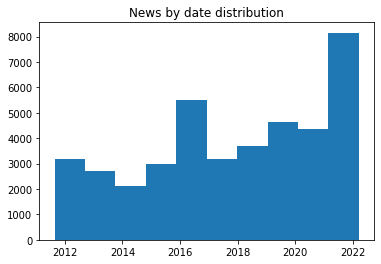

In [8]:
plt.hist(
    data_cat2date.date[data_cat2date.date.notnull()],
);
plt.title("News by date distribution");

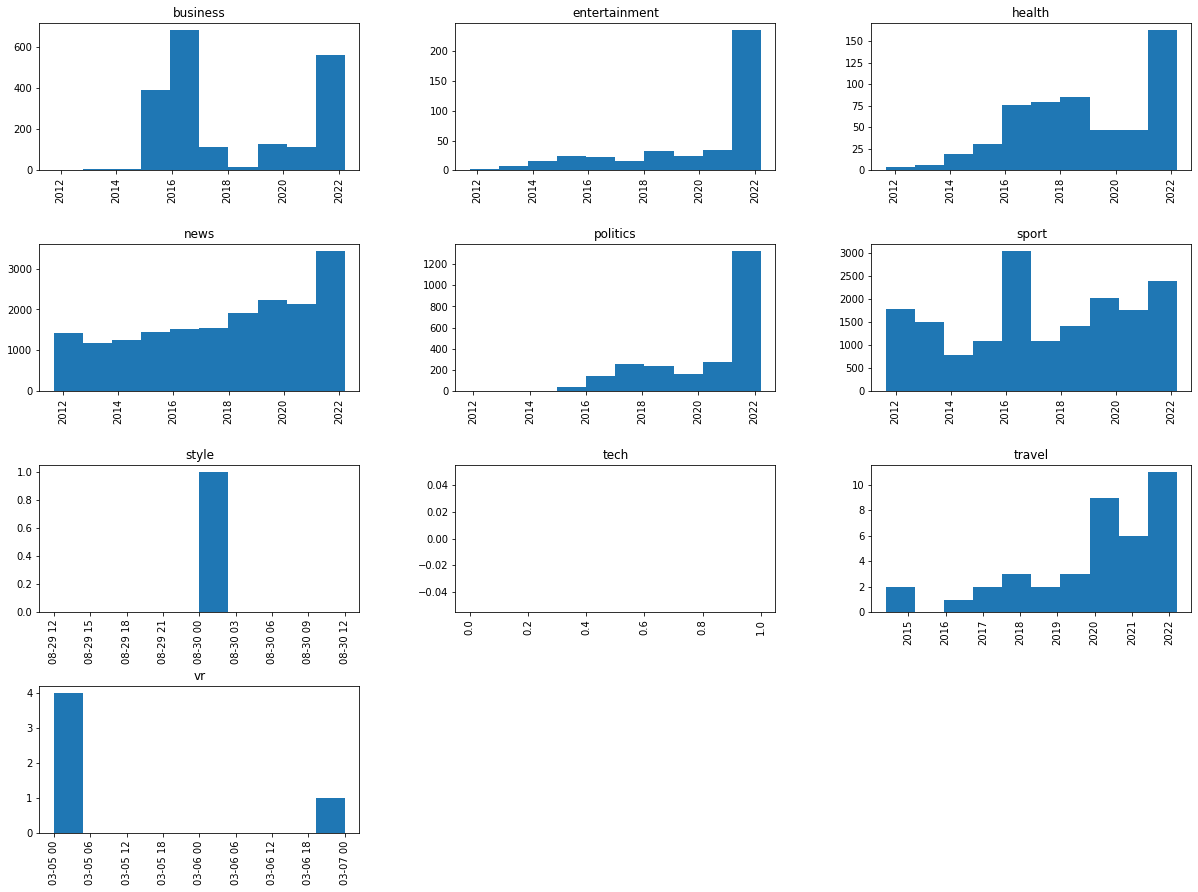

In [9]:
data_cat2date.date.hist(
    by=data_cat2date.category,
    figsize=(20,15)
);

## Models

In [ ]:
from tqdm import tqdm

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
categories = {
    "DATA": [_["category"] for _ in data]
}

In [ ]:
def categorize(news: dict, features: list):
    """Categorizes the news

    Parameters
    ----------
    news: dict containing information about the news

    features: fields of the dict to predict on
    """

    text = " ".join([
        news[feature]
        for feature in features if isinstance(news[feature], str)
    ])
    return predict(text)

### [nateraw/bert-base-uncased-ag-news](https://huggingface.co/nateraw/bert-base-uncased-ag-news)

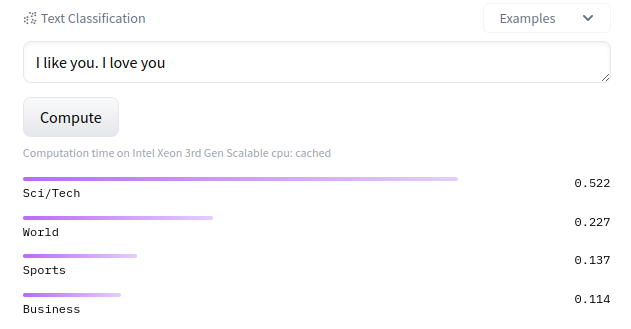

In [10]:
categories_mapper = {"MODEL1": {
    "business": "Business",
    
    "sport": "Sports",
    
    "tech": "Sci/Tech",
    "vr": "Sci/Tech",
    "health": "Sci/Tech",   # to be checked
    
    "entertainment": "World",
    "politics": "World",
    "news": "World",
    # "health": "World",
    "travel": "World",
    "style": "World", 
}}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-ag-news")
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-ag-news").to(device)
model_mapping = model.config.id2label

def eval(text : str):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output[0][0].cpu().tolist()

def predict(text: str):
    probs = softmax(eval(text))
    return {
        model_mapping[i]: probs[i]
        for i in range(len(probs))
    }

def get_category(pred: dict):
    return max(pred, key=lambda cat: pred[cat])

In [ ]:
data[0]["category"]

'business'

In [ ]:
predict(data[0]["title"])

{'World': 0.006959069176990349,
 'Sports': 0.0006533050266948417,
 'Business': 0.8900001495307923,
 'Sci/Tech': 0.10238747626552237}

In [ ]:
categorize(data[0], ["title"])

{'World': 0.006959069176990349,
 'Sports': 0.0006533050266948417,
 'Business': 0.8900001495307923,
 'Sci/Tech': 0.10238747626552237}

In [ ]:
res = categorize(data[0], ["title", "description"])
get_category(res)

'Business'

In [ ]:
predictions = []
for news in tqdm(data):
    predictions.append(
        get_category(categorize(
            news,
            ["title", "description"]
        ))
    )
categories["MODEL1"] = predictions

100%|██████████| 42635/42635 [09:49<00:00, 72.36it/s]


### [mrm8488/bert-mini-finetuned-age_news-classification](https://huggingface.co/mrm8488/bert-mini-finetuned-age_news-classification)

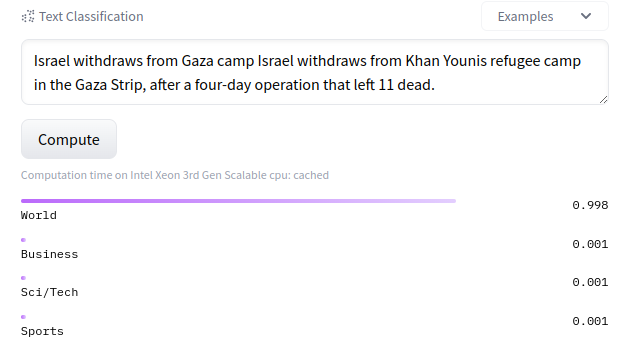

In [11]:
categories_mapper["MODEL2"] = {
    "business": "Business",
    
    "sport": "Sports",
    
    "tech": "Sci/Tech",
    "vr": "Sci/Tech",
    "health": "Sci/Tech",   # to be checked
    
    "entertainment": "World",
    "politics": "World",
    "news": "World",
    # "health": "World",
    "travel": "World",
    "style": "World", 
}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-mini-finetuned-age_news-classification")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-mini-finetuned-age_news-classification").to(device)
model_mapping = model.config.id2label

def eval(text : str):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output[0][0].cpu().tolist()

def predict(text: str):
    probs = softmax(eval(text))
    return {
        model_mapping[i]: probs[i]
        for i in range(len(probs))
    }

def get_category(pred: dict):
    return max(pred, key=lambda cat: pred[cat])

In [ ]:
predictions = []
for news in tqdm(data):
    predictions.append(
        get_category(categorize(
            news,
            ["title", "description"]
        ))
    )
categories["MODEL2"] = predictions

100%|██████████| 42635/42635 [04:00<00:00, 177.11it/s]


### [abhishek/autonlp-bbc-news-classification-37229289](https://huggingface.co/abhishek/autonlp-bbc-news-classification-37229289)

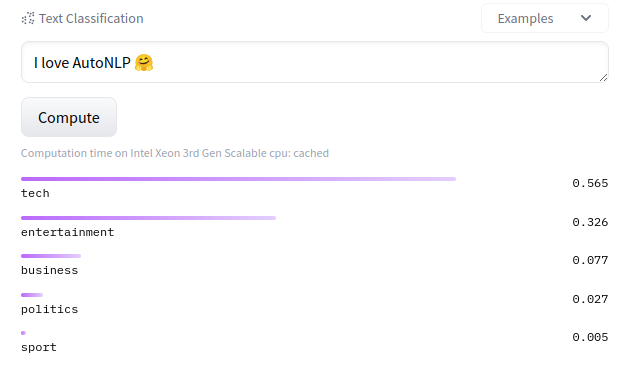

In [12]:
categories_mapper["MODEL3"] = {
    "business": "business",
    
    "politics": "politics",
    
    "sport": "sport",
    
    "tech": "tech",
    "vr": "tech",
    "health": "tech",   # to be checked
    
    "entertainment": "entertainment",
    "news": "entertainment",
    "travel": "entertainment",
    "style": "entertainment", 
}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("abhishek/autonlp-bbc-news-classification-37229289")
model = AutoModelForSequenceClassification.from_pretrained("abhishek/autonlp-bbc-news-classification-37229289").to(device)
model_mapping = model.config.id2label

def eval(text : str):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output[0][0].cpu().tolist()

def predict(text: str):
    probs = softmax(eval(text))
    return {
        model_mapping[i]: probs[i]
        for i in range(len(probs))
    }

def get_category(pred: dict):
    return max(pred, key=lambda cat: pred[cat])

In [ ]:
predictions = []
for news in tqdm(data):
    predictions.append(
        get_category(categorize(
            news,
            ["title", "description"]
        ))
    )
categories["MODEL3"] = predictions

100%|██████████| 42635/42635 [21:52<00:00, 32.48it/s]


### [cardiffnlp/twitter-roberta-base-dec2021-tweet-topic-multi-all](https://huggingface.co/cardiffnlp/twitter-roberta-base-dec2021-tweet-topic-multi-all)

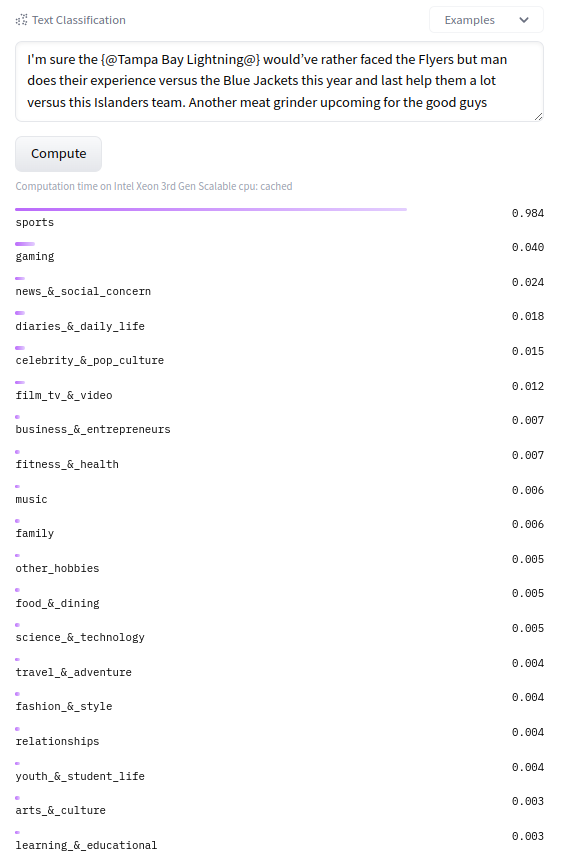

In [13]:
categories_mapper["MODEL4"] = {
    "business": "business_&_entrepreneurs",
    
    "entertainment": "arts_&_culture",
    
    "sport": "sports",
    
    "health": "fitness_&_health",
    
    "tech": "science_&_technology",
    "vr": "science_&_technology",
    
    "travel": "travel_&_adventure",
    
    "style": "fashion_&_style", 
    
    # idk
    "news": "other_hobbies",
    "politics": "other_hobbies",
}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-dec2021-tweet-topic-multi-all")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-dec2021-tweet-topic-multi-all").to(device)
model_mapping = model.config.id2label

def eval(text : str):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output[0][0].cpu().tolist()

def predict(text: str):
    probs = softmax(eval(text))
    return {
        model_mapping[i]: probs[i]
        for i in range(len(probs))
    }

def get_category(pred: dict):
    return max(pred, key=lambda cat: pred[cat])

In [ ]:
predictions = []
for news in tqdm(data):
    predictions.append(
        get_category(categorize(
            news,
            ["title", "description"]
        ))
    )
categories["MODEL4"] = predictions

100%|██████████| 42635/42635 [10:08<00:00, 70.07it/s]


### [jonaskoenig/topic_classification_04](https://huggingface.co/jonaskoenig/topic_classification_04?text=I+like+you.+I+love+you)

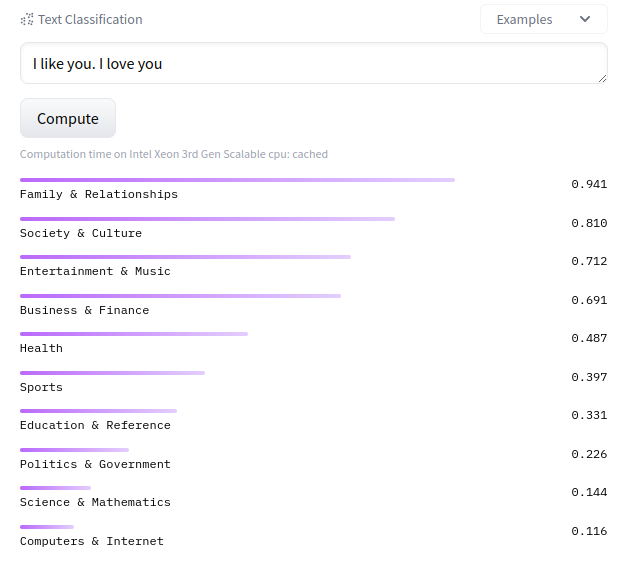

## Predictions' analysis

In [ ]:
with open("/content/up_nlp/MyDrive/up_nlp/categories.json", "w") as categories_file:
    categories_file.write(json.dumps(categories))

In [14]:
with open("/content/up_nlp/MyDrive/up_nlp/categories.json", "r") as categories_file:
    categories = json.load(categories_file)

In [15]:
categories.keys()

dict_keys(['DATA', 'MODEL1', 'MODEL2', 'MODEL3', 'MODEL4'])

In [16]:
categories_mapper.keys()

dict_keys(['MODEL1', 'MODEL2', 'MODEL3', 'MODEL4'])

[Multi-Class Metrics Made Simple, Part I: Precision and Recall](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)

[Multi-Class Metrics Made Simple, Part II: the F1-score](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1)

In [17]:
from sklearn import metrics

In [18]:
print(metrics.classification_report(
    [categories_mapper["MODEL1"][cat] for cat in categories["DATA"]],
    categories["MODEL1"],
    digits=3
))

              precision    recall  f1-score   support

    Business      0.613     0.637     0.625      2534
    Sci/Tech      0.105     0.736     0.183       909
      Sports      0.975     0.837     0.901     17439
       World      0.870     0.745     0.803     21753

    accuracy                          0.776     42635
   macro avg      0.641     0.739     0.628     42635
weighted avg      0.881     0.776     0.819     42635



In [19]:
print(metrics.classification_report(
    [categories_mapper["MODEL2"][cat] for cat in categories["DATA"]],
    categories["MODEL2"],
    digits=3
))

              precision    recall  f1-score   support

    Business      0.323     0.676     0.437      2534
    Sci/Tech      0.103     0.629     0.177       909
      Sports      0.957     0.829     0.889     17439
       World      0.846     0.647     0.733     21753

    accuracy                          0.723     42635
   macro avg      0.557     0.696     0.559     42635
weighted avg      0.844     0.723     0.767     42635



In [20]:
print(metrics.classification_report(
    [categories_mapper["MODEL3"][cat] for cat in categories["DATA"]],
    categories["MODEL3"],
    digits=3
))

               precision    recall  f1-score   support

     business      0.188     0.717     0.298      2534
entertainment      0.636     0.279     0.388     18889
     politics      0.252     0.676     0.367      2864
        sport      0.965     0.791     0.870     17439
         tech      0.170     0.504     0.255       909

     accuracy                          0.546     42635
    macro avg      0.442     0.594     0.435     42635
 weighted avg      0.708     0.546     0.575     42635



In [21]:
print(metrics.classification_report(
    [categories_mapper["MODEL4"][cat] for cat in categories["DATA"]],
    categories["MODEL4"],
    digits=3
))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

          arts_&_culture      0.106     0.015     0.027       782
business_&_entrepreneurs      0.889     0.200     0.327      2534
 celebrity_&_pop_culture      0.000     0.000     0.000         0
    diaries_&_daily_life      0.000     0.000     0.000         0
                  family      0.000     0.000     0.000         0
         fashion_&_style      0.023     1.000     0.045         1
         film_tv_&_video      0.000     0.000     0.000         0
        fitness_&_health      0.318     0.075     0.122       557
           food_&_dining      0.000     0.000     0.000         0
                  gaming      0.000     0.000     0.000         0
  learning_&_educational      0.000     0.000     0.000         0
                   music      0.000     0.000     0.000         0
   news_&_social_concern      0.000     0.000     0.000         0
           other_hobbies      0.000     0.000     0.000     20931
    scien

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
